<a href="https://colab.research.google.com/github/soulayman-al-abdallah/ML-Petro-well-log-lithology/blob/main/4_classification_lithology_tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lithology classification** - Pytorch-tabnet
-----




Since the **total.df** is ready with filled NPHI values, we will start the **predictive modeling of the geological lithology**, represented with the **LITHOLOGY_GEOLINK**.



---



---



---



# Importing modules and dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import time
import multiprocessing

from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Dev tools/Data - NorthSea Electrofacies/Generated Dataframes/total_df.csv.gz', compression='gzip')
df.head(3)

,DEPTH,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,LITHOLOGY_GEOLINK
0,970.784973,19.379000,0.476293,1.925953,34.463940,150.259949,3.274985,0.371132,NaN
1,970.937378,20.042002,0.433137,1.930004,37.689102,149.147537,1.775984,0.627568,NaN
2,971.089783,20.993999,0.464309,1.931051,39.453999,148.786880,1.025920,0.756454,NaN


## Class Balance of LITHO

Text(0.5, 1.0, 'Lithology Classes - Target Variable Balance')

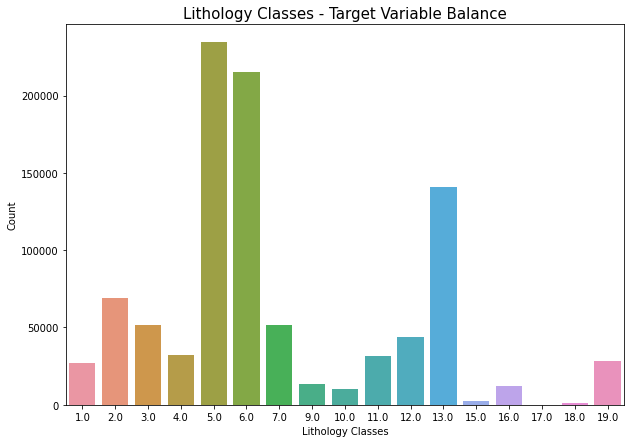

In [ ]:
#target variable classes balance
plt.figure(figsize=(10,7))

sns.barplot(x=df['LITHOLOGY_GEOLINK'].value_counts().index, y=df['LITHOLOGY_GEOLINK'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Lithology Classes - Target Variable Balance', fontsize=15)



---



In [ ]:
file_path = '/content/gdrive/MyDrive/Dev tools/Data - NorthSea Electrofacies/Generated Dataframes/litho_code.csv.gz'

litho_code = pd.read_csv(file_path , compression='gzip')

In [ ]:
litho_code[['Lithology Attribute','Abbreviation']]

,Lithology Attribute,Abbreviation
0,CrossBedded Sand,35.0
1,Anhydrite,22.0
2,Chalk,12.0
3,Gravel,36.0
4,Intrusive,23.0
5,Sandy Shale,25.0
6,Sandy Limestone,16.0
7,Breccia,31.0
8,Calcareous Shale,14.0
9,Halite,33.0


⚓ As per the df shown above, from the litho_code df data, we can combine the abbreviations 1,2,3 together since they're all have "Sand" as the lithology attribute, same applies to some other abbreviations...

In [ ]:
df['LITHOLOGY_GEOLINK_NEW'] = df['LITHOLOGY_GEOLINK']

for code in df.index:

    if (df['LITHOLOGY_GEOLINK_NEW'][code] == 2 or df['LITHOLOGY_GEOLINK_NEW'][code] == 3):
        df['LITHOLOGY_GEOLINK_NEW'][code] = 1

    elif df['LITHOLOGY_GEOLINK_NEW'][code] == 6:
        df['LITHOLOGY_GEOLINK_NEW'][code] = 5

    elif df['LITHOLOGY_GEOLINK_NEW'][code] == 34:
        df['LITHOLOGY_GEOLINK_NEW'][code] = 33


    elif df['LITHOLOGY_GEOLINK_NEW'][code] == 13:
        df['LITHOLOGY_GEOLINK_NEW'][code] = 12

    else:
        pass



---



Text(0.5, 1.0, 'Lithology Classes - Target Variable Balance')

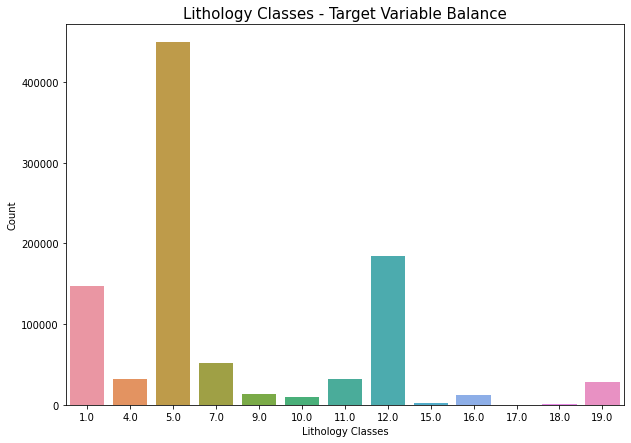

In [ ]:
#visualizing the new classes balance of the target variable
plt.figure(figsize=(10,7))

sns.barplot(x=df['LITHOLOGY_GEOLINK_NEW'].value_counts().index, y=df['LITHOLOGY_GEOLINK_NEW'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Lithology Classes - Target Variable Balance', fontsize=15)



---



# Feature Engineering

## Adding a column of DRDN and Acoustic Impedance values

In [ ]:
df['DRDN'] = ((df['RHOB'] - 2)/0.05) - ((0.45 - df['NPHI'])/0.03)
df['AI'] = df['RHOB'] * (1e6/df['DTC']) * 0.3048



(mu_DRDN, sigma_DRDN) = stats.norm.fit(df[df.DRDN.notnull()].DRDN.values)
(mu_AI, sigma_AI) = stats.norm.fit(df[df.AI.notnull()].AI.values)


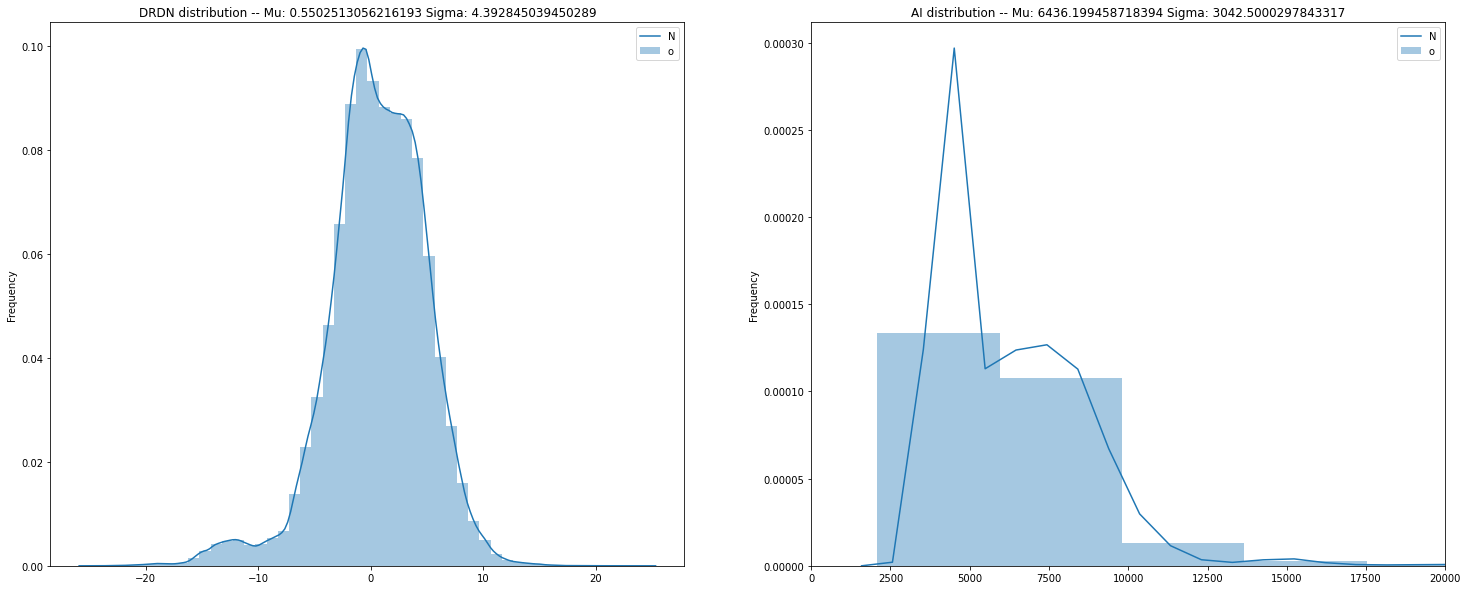

In [ ]:
plt.figure(figsize=(25,10))

plt.subplot(121)
(mu, sigma) = stats.norm.fit(df[df.DRDN.notnull()].DRDN.values)
sns.distplot(df[df.DRDN.notnull()].DRDN.values)
plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('DRDN distribution -- Mu:' + ' ' + str(mu_DRDN) + ' ' + 'Sigma:' + ' ' + str(sigma_DRDN) )

plt.subplot(122)
sns.distplot(df[df.AI.notnull()].AI.values)
plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.xlim([0, 20000])
plt.title('AI distribution -- Mu:' + ' ' + str(mu_AI) + ' ' + 'Sigma:' + ' ' + str(sigma_AI) )

plt.show()



---



# Modeling

In [ ]:
df.head(3)

,DEPTH,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,LITHOLOGY_GEOLINK,LITHOLOGY_GEOLINK_NEW,DRDN,AI
0,970.784973,19.379000,0.476293,1.925953,34.463940,150.259949,3.274985,0.371132,NaN,NaN,-0.604492,3906.766407
1,970.937378,20.042002,0.433137,1.930004,37.689102,149.147537,1.775984,0.627568,NaN,NaN,-1.962014,3944.183015
2,971.089783,20.993999,0.464309,1.931051,39.453999,148.786880,1.025920,0.756454,NaN,NaN,-0.902005,3955.888037


In [ ]:
#Data that has non-null LITHOLOGY_GEOLINK_NEW values
litho_data = df[pd.notnull(df['LITHOLOGY_GEOLINK_NEW'])].drop(columns=['LITHOLOGY_GEOLINK']) # litho2 optimum set (84.5)
print(litho_data.shape)
litho_data.head(3)

(964961, 11)


,DEPTH,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,LITHOLOGY_GEOLINK_NEW,DRDN,AI
5184,1760.826538,11.072,0.497564,2.100449,49.180531,152.926773,0.701026,0.635005,5.0,3.594446,4186.428191
5185,1760.979004,11.414,0.487431,2.101901,49.398258,154.804123,0.712035,0.636930,5.0,3.285710,4138.517127
5186,1761.131348,11.862,0.470989,2.114949,48.853848,153.791382,0.723002,0.614947,5.0,2.998615,4191.628285


In [ ]:
# convert to int dtype
litho_data['LITHOLOGY_GEOLINK_NEW'] = litho_data['LITHOLOGY_GEOLINK_NEW'].astype(int)
litho_data.head(3)

,DEPTH,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,LITHOLOGY_GEOLINK_NEW,DRDN,AI
5184,1760.826538,11.072,0.497564,2.100449,49.180531,152.926773,0.701026,0.635005,5,3.594446,4186.428191
5185,1760.979004,11.414,0.487431,2.101901,49.398258,154.804123,0.712035,0.636930,5,3.285710,4138.517127
5186,1761.131348,11.862,0.470989,2.114949,48.853848,153.791382,0.723002,0.614947,5,2.998615,4191.628285


In [ ]:
#dataset creation
from sklearn.model_selection import train_test_split

X = litho_data.drop(columns='LITHOLOGY_GEOLINK_NEW')
Y = litho_data['LITHOLOGY_GEOLINK_NEW'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42) # close to the tabnet training dataset size

print('Training Dataset:  ', x_train.shape, y_train.shape)
print('Test Dataset: ', x_test.shape, y_test.shape)

Training Dataset:   (771968, 10) (771968,)
Test Dataset:  (192993, 10) (192993,)


Fitting the model on data

In [ ]:
import torch
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier


clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"gamma":0.9, "step_size":50},
                       gamma=1.2,
                       lambda_sparse=0, 
                       n_independent=10,
                       n_shared=5,	
                       n_steps=5,
                       n_a=64,
                       n_d=64,
                       momentum=0.6, 
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax') 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 703 kB/s 


In [ ]:
#normalizing data

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

x_train = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

In [ ]:
max_epochs = 70

clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    eval_name=['train', 'test'],
    eval_metric=['balanced_accuracy'],
    max_epochs=max_epochs,
    patience=30,
    num_workers=30,
    drop_last=False,
    batch_size=8192,
    virtual_batch_size=8192,
    weights=1
)

epoch 0  | loss: 3.45524 | train_balanced_accuracy: 0.28701 | test_balanced_accuracy: 0.28972 |  0:00:46s
epoch 1  | loss: 2.3099  | train_balanced_accuracy: 0.49425 | test_balanced_accuracy: 0.48183 |  0:01:31s
epoch 2  | loss: 1.43371 | train_balanced_accuracy: 0.61739 | test_balanced_accuracy: 0.61061 |  0:02:12s
epoch 3  | loss: 1.01085 | train_balanced_accuracy: 0.68495 | test_balanced_accuracy: 0.67658 |  0:02:46s
epoch 4  | loss: 0.82639 | train_balanced_accuracy: 0.70885 | test_balanced_accuracy: 0.70346 |  0:03:21s
epoch 5  | loss: 0.71465 | train_balanced_accuracy: 0.77369 | test_balanced_accuracy: 0.76182 |  0:03:55s
epoch 6  | loss: 0.59486 | train_balanced_accuracy: 0.78669 | test_balanced_accuracy: 0.77183 |  0:04:30s
epoch 7  | loss: 0.53955 | train_balanced_accuracy: 0.81949 | test_balanced_accuracy: 0.79858 |  0:05:04s
epoch 8  | loss: 0.49707 | train_balanced_accuracy: 0.81434 | test_balanced_accuracy: 0.78606 |  0:05:41s
epoch 9  | loss: 0.47888 | train_balanced_accu

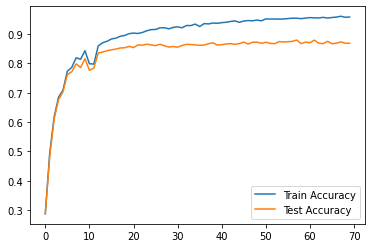

In [ ]:
plt.plot(clf.history['train_balanced_accuracy'], label='Train Accuracy')
plt.plot(clf.history['test_balanced_accuracy'], label='Test Accuracy')
plt.legend()
plt.show()

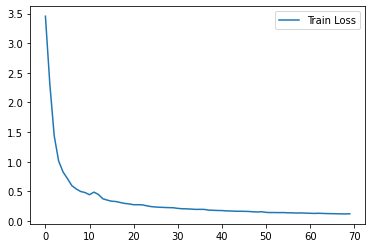

In [ ]:
plt.plot(clf.history['loss'], label='Train Loss')
plt.legend()
plt.show()

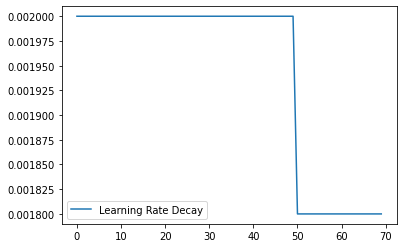

In [ ]:
plt.plot(clf.history['lr'], label='Learning Rate Decay')
plt.legend()
plt.show()



---



In [ ]:
start_time = time.time()

y_predict = clf.predict(std_scaler.fit_transform(x_test))

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

0.0 minutes taken


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score

print('Accuracy: ', str(accuracy_score(y_test, y_predict)), '\n')
print('########################', '\n')
print('Balanced Accuracy: ', str(balanced_accuracy_score(y_test, y_predict)))
print('########################', '\n')
print('F1-Score Micro: ', str(f1_score(y_test, y_predict, average='weighted')))

Accuracy:  0.8483364681620577 

######################## 

Balanced Accuracy:  0.8798831870368657
######################## 

F1-Score Micro:  0.8556769361421666


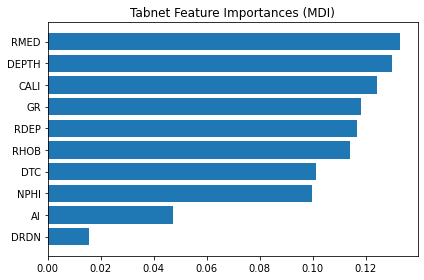

In [ ]:
tab_feature_importances = (clf.feature_importances_)
sorted_idx = tab_feature_importances.argsort()
y_ticks = np.arange(0, len(X.columns))
fig, ax = plt.subplots()
ax.barh(y_ticks, tab_feature_importances[sorted_idx])
ax.set_yticklabels(X.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Tabnet Feature Importances (MDI)")
fig.tight_layout()
plt.show()

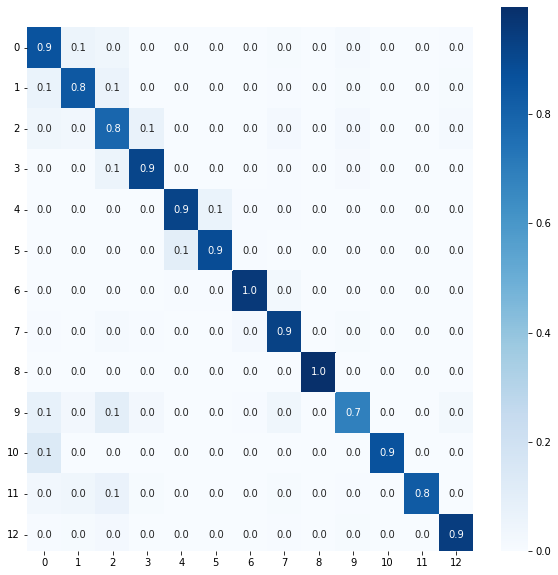

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_predict)

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cf_matrix.astype('float')/ cf_matrix.sum(axis=1)[:, np.newaxis], cmap=plt.cm.Blues, annot=True, fmt='.1f') # confusion matrix normalized as in Sklearn documentation

plt.yticks(rotation=0) 

ax.set_ylim(len(cf_matrix)-0.1, -0.5)

plt.show()